# Project 4: Natural Language Processing 
---

**Group 9: Aidan Stocks, Hugo Reinicke, Nicola Clark, Jonas-Mika Senghaas**

Submission: *03.06.2021* / Last Modified: *27.04.2021*

---

This notebook contains the step-by-step data science process performed *XXX*. The goal of this project was to *XXX*.

The initial data was obtained from the [TweetEval](https://github.com/cardiffnlp/tweeteval#evaluating-your-system) GitHub repository, that provides data for supervised training of classifiers for natural language processing.

## Introduction
---
*XXX*

## Running this Notebook
---
This notebook contains all code to reproduce the findings of the project as can be seen on the [GitHub](https://github.com/jonas-mika/fyp2021p04g09) page of this project. In order to read in the data correctly, the global paths configured in the section `Constants` need to be correct. The following file structure - as prepared in the `submission.zip` - was followed throughout the project and is recommended to use (alternatively the paths in the section `Constants` can be adjusted):

```
*project tree structure*
```
*Note that the rest of the file structure as can be seen on the [GitHub](https://github.com/jonas-mika/fyp2021p03g09) page of the project generates automatically*

## Required Libraries and Further Imports
---
Throughout the project, we will use a range of both built-in and external Python libraries. This notebook will only run if all libraries and modules are correctly installed on your local machines. 
To install missing packages use `pip install <package_name>` (PIP (Python Package Index) is the central package management system, read more [here](https://pypi.org/project/pip/)). 

In case you desire further information about the used packages, click the following links to find detailed documentations:
- [Pandas](https://pandas.pydata.org/)
- [Numpy](https://numpy.org/)
- [Matplotlib](https://matplotlib.org/stable/index.html)
- [PIL](https://pillow.readthedocs.io/en/stable/)
- [SciKit Learn](https://scikit-learn.org/stable/)
- [SciKit Image](https://scikit-image.org/)
- [Scipy](https://www.scipy.org/)

In [172]:
%%capture
# uncomment lines with uninstalled packages

#!pip install -U numpy pandas matplotlib seaborn skikit-learn 
!pip install pycontractions
!pip install imblearn

In [2]:
# python standard libraries
import json                                            # data transfer to and from json format
import os                                              # access operating system from python
import math                                            # mathematical operations in python
import random                                          # creates randomness
import re                                              # regex search in python
import shutil                                          # system control in python
import warnings                                        # ignore annoying warnings
warnings.filterwarnings("ignore")

# external libraries
import numpy as np                                     # used for numerical calculations and fast array manipulations
import pandas as pd                                    # provides major datastructure pd.DataFrame() to store datasets
import matplotlib
import matplotlib.pyplot as plt                        # basic data visualisation
import seaborn as sns                                  # advanced data visualisation
from nltk.tokenize import TweetTokenizer               # tokeniser api
from pycontractions import Contractions                # intelligently expands contractions in natural language
from collections import Counter                        # counts objects

In [3]:
print(f'Numpy Version: {np.__version__}')
print(f'Pandas Version: {pd.__version__}')
print(f'Matplotlib Version: {matplotlib.__version__}')
print(f'Seaborn Version: {sns.__version__}')

Numpy Version: 1.19.5
Pandas Version: 1.2.4
Matplotlib Version: 3.4.2
Seaborn Version: 0.11.1


Since this project makes heavy use of functions to achieve maximal efficiency, all functions are stored externally in the package structure `project3'. The following imports are necessary for this notebook to run properly.

In [4]:
#from project4.processing import ...
#from project4.save import ...
#from project4.features import ...

## Constants
---
To enhance readibilty, as well as to decrease the maintenance effort, it is useful for bigger projects to define contants that need to be accessed globally throughout the whole notebook in advance. 
The following cell contains all of those global constants. By convention, we write them in caps (https://www.python.org/dev/peps/pep-0008/#constants)

In [5]:
PREPROCESS_DATA = False

In [6]:
DATASETS = ['hate', 'emotion']

# store paths
PATH = {}
PATH['data'] = {}
PATH['data']['raw'] = "../data/raw/"
PATH['data']['processed'] = "../data/processed/"

# store data 
DATA = {}
DATA['raw'] = {}
DATA['processed'] = {}
for dataset in DATASETS:
    DATA['raw'][dataset] = {}
    DATA['processed'][dataset] = {}

*TASK 0*
# Fetching Data
---

## Loading in Data
---

In [7]:
def read_raw_input(dataset):
    # reading in all .txts into list of strings
    for _file in os.listdir(f'../data/raw/{dataset}'):
        with open(f'../data/raw/{dataset}/{_file}', 'r', encoding='UTF-8') as infile:
            DATA['raw'][dataset][_file[:-4]] = [line.strip() for line in infile.readlines()]

    # convert target labels to integers
    for key in ['train_labels', 'val_labels', 'test_labels']:
        DATA['raw'][dataset][key] = [int(x) for x in DATA['raw'][dataset][key]]

    # convert mapping to dictionary
    DATA['raw'][dataset]['mapping'] = {int(string.split('\t')[0]): string.split('\t')[1] for string in DATA['raw'][dataset]['mapping']}

In [8]:
for dataset in DATASETS:
    read_raw_input(dataset)

## Exploring Data
---

### Peek into Training Tweets

In [9]:
# hate
for i in range(10):
    print(f"{i+1}\tLabel: {DATA['raw']['hate']['mapping'][DATA['raw']['hate']['train_labels'][i]].title()}\t\t{DATA['raw']['hate']['train_text'][i]}")

1	Label: Not-Hate		@user nice new signage. Are you not concerned by Beatlemania -style hysterical crowds crongregating on you…
2	Label: Hate		A woman who you fucked multiple times saying yo dick small is a compliment you know u hit that spot 😎
3	Label: Hate		@user @user real talk do you have eyes or were they gouged out by a rapefugee?
4	Label: Hate		your girlfriend lookin at me like a groupie in this bitch!
5	Label: Not-Hate		Hysterical woman like @user
6	Label: Not-Hate		Me flirting- So tell me about your father...
7	Label: Not-Hate		The Philippine Catholic bishops' work for migrant workers should focus on families who are "paying the great...
8	Label: Hate		I AM NOT GOING AFTER YOUR EX BF YOU LIEING SACK OF SHIT ! I'm done with you dude that's why I dumped your ass cause your a lieing 😂😡 bitch
9	Label: Not-Hate		When cuffin season is finally over
10	Label: Hate		Send home migrants not in need of protection, Peter Dutton tells UN, HEY DUTTON HOW ABOUT THE ONES THAT HAVE STAYED AND NO

In [10]:
# emotion
for i in range(10):
    print(f"{i+1}\tLabel: {DATA['raw']['emotion']['mapping'][DATA['raw']['emotion']['train_labels'][i]].title()}\t\t{DATA['raw']['emotion']['train_text'][i]}")

1	Label: Optimism		“Worry is a down payment on a problem you may never have'.  Joyce Meyer.  #motivation #leadership #worry
2	Label: Anger		My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs
3	Label: Joy		No but that's so cute. Atsu was probably shy about photos before but cherry helped her out uwu
4	Label: Anger		Rooneys fucking untouchable isn't he? Been fucking dreadful again, depay has looked decent(ish)tonight
5	Label: Sadness		it's pretty depressing when u hit pan on ur favourite highlighter
6	Label: Anger		@user but your pussy was weak from what I heard so stfu up to me bitch . You got to threaten him that your pregnant .
7	Label: Sadness		Making that yearly transition from excited and hopeful college returner to sick and exhausted pessimist. #college
8	Label: Joy		Tiller and breezy should do a collab album. Rapping and singing prolly be fire
9	Label: Anger		@user broadband is shocking regretting signing up now #angry #shouldofgone

### Visualising Label Distribution

In [11]:
def visualise_label_distribution(dataset):
    fig, ax = plt.subplots(ncols=3, figsize=(12,4))
    fig.suptitle(f'Frequency of Target Label in {dataset.capitalize()}', fontsize=12, fontweight='bold')

    for i, key in enumerate(['train_labels', 'val_labels', 'test_labels']):
        label, count = np.unique(DATA['raw'][dataset][key], return_counts=True)
        ax[i].bar(label, count, color='grey');
        ax[i].set_title(key.replace('_', ' ').title())
        ax[i].set_xticks(label); ax[i].set_xticklabels([string.title() for string in DATA['raw'][dataset]['mapping'].values()])

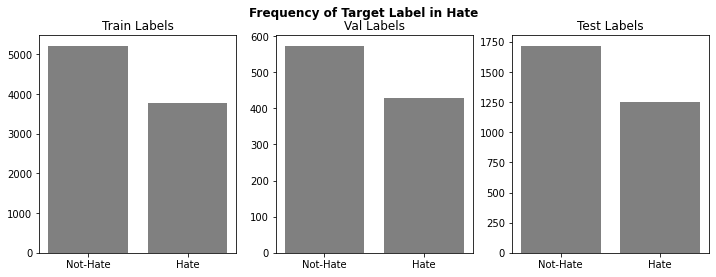

In [12]:
visualise_label_distribution(dataset='hate')

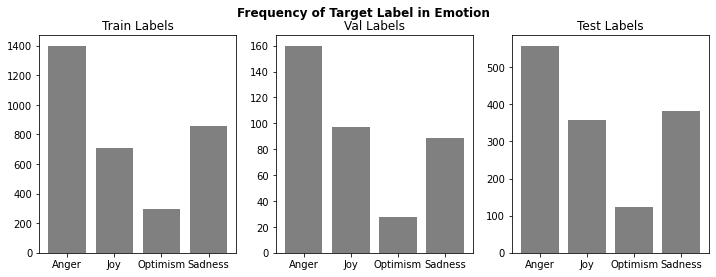

In [13]:
visualise_label_distribution(dataset='emotion')

*TASK 0.5*
# Processing of Language Data
---


### Tokenize Tweets
---


## Final Tokenising

Improving on the Tweet Tokenizer:
* lowercasing 
* expanding contractions
* change links to a dummy value

In [19]:
# define url regex pattern and replace pattern globally (compile for speedup)
url_pattern = re.compile(r"(?i)((?:https?://|www\d{0,3}[.]|[a-z0-9.-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|(([^\s()<>]+|(([^\s()<>]+)))))+(?:(([^\s()<>]+|(([^\s()<>]+))))|[^\s`!()[]{};:'\".,<>?«»\“\”‘’]))")
dummy = " <=LINK=> "

# brush up functions
def remove_links(tweet):
    return re.sub(url_pattern, dummy, tweet) 

def remove_newline(tweet):
    return re.sub(r'\\n', ' ', tweet)

# loading pre-trained contraction model
cont = Contractions(api_key="glove-twitter-200")

def expand(tweet):
    return list(cont.expand_texts([tweet]))[0]

if PREPROCESS_DATA == True:
    cont.load_models() # doesn't work on deepnote, because of memory issues 

In [23]:
tk = TweetTokenizer()

def clean(tweet):
    cleaned_tweet = expand(remove_links(remove_newline(tweet.lower())))
    return tk.tokenize(cleaned_tweet)

In [26]:
if PREPROCESS_DATA == True:
    for dataset in DATASETS:
        # create preprocessed folder
        try: os.makedirs(f'../data/processed/{dataset}')
        except: None

        # preprocess and tokenize tweets
        for key in ['train_text', 'val_text', 'test_text']:
            with open(f'../data/processed/{dataset}/{key}.txt', 'w', encoding = 'UTF-8') as outfile:
                for tweet in DATA['raw'][dataset][key]:
                    outfile.write('\t'.join(clean(tweet)) + '\n') # writing tokenised tweet with tab delimiter

        # copy labels and mapping without preprocessing
        for key in ['train_labels', 'val_labels', 'test_labels', 'mapping']:
            shutil.copyfile(f'../data/raw/{dataset}/{key}.txt', f'../data/processed/{dataset}/{key}.txt')

In [27]:
# loading in processed data
for dataset in DATASETS:
    for key in os.listdir(f'../data/processed/{dataset}'):
        with open(f'../data/processed/{dataset}/{key}', 'r', encoding='UTF-8') as infile:
            DATA['processed'][dataset][key[:-4]] = [line.strip().split('\t') for line in infile.readlines()]

    # convert target labels to integers
    for key in ['train_labels', 'val_labels', 'test_labels']:
        DATA['processed'][dataset][key] = [int(x) for x in [DATA['processed'][dataset][key][i][0] for i in range(len(DATA['processed'][dataset][key]))]]

    # convert mapping to dictionary
    DATA['processed'][dataset]['mapping'] = {int(string[0]): string[1] for string in DATA['processed'][dataset]['mapping']}

*TASK 1* 
# Descriptive Statistics about Natural Language Data
---

In [28]:
CORPUS = {}
for dataset in DATASETS:
    CORPUS[dataset] = [token for tweet in DATA['processed'][dataset]['train_text'] for token in tweet]

In [29]:
# build entire alphabet from training tweets
VOCABULARY = {}
for dataset in DATASETS:
    corpus = CORPUS[dataset]

    # initialise frequency counter
    VOCABULARY[dataset] = pd.DataFrame.from_dict(Counter(corpus), orient='index').rename(columns={'index': 'token', 0: 'frequency'}).sort_values(by='frequency', ascending=False).reset_index()

    VOCABULARY[dataset]['rank'] = VOCABULARY[dataset].index + 1 # add one to index to build rank
    VOCABULARY[dataset]['normalised_frequency'] = VOCABULARY[dataset]['frequency'] / VOCABULARY[dataset]['frequency'].sum() # relative frequency
    VOCABULARY[dataset]['cumulative_frequency'] = VOCABULARY[dataset]['normalised_frequency'].cumsum()

In [30]:
VOCABULARY['hate']

,index,frequency,rank,normalised_frequency,cumulative_frequency
0,.,6277,1,0.029050,0.029050
1,@user,6014,2,0.027833,0.056883
2,the,5492,3,0.025417,0.082300
3,to,4931,4,0.022821,0.105120
4,",",4356,5,0.020160,0.125280
...,...,...,...,...,...
18595,weren,1,18596,0.000005,0.999981
18596,miaow-miaow-miaow,1,18597,0.000005,0.999986
18597,aaaaw,1,18598,0.000005,0.999991
18598,food-hole,1,18599,0.000005,0.999995


## Hate Plots

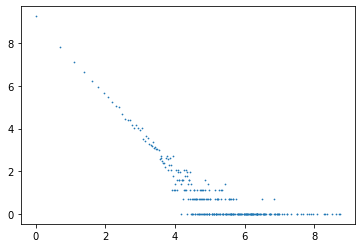

In [31]:
#dict(Counter(VOCABULARY['hate']['frequency']))
import math
frequency, frequency_of_frequency = np.unique(VOCABULARY['hate']['frequency'], return_counts=True)
fig, ax = plt.subplots()
ax.scatter([math.log(f) for f in frequency], [math.log(f) for f in frequency_of_frequency],s=0.5)

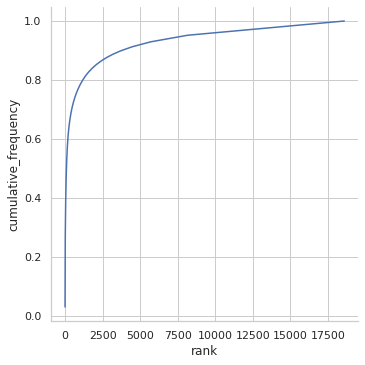

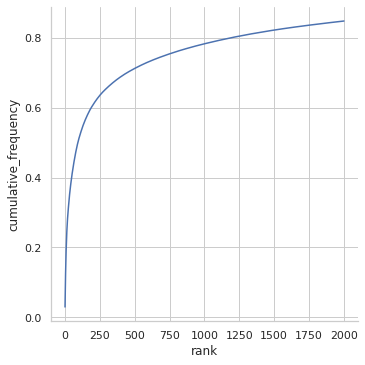

In [32]:
# plots
sns.set_theme(style='whitegrid')

# Plot: Cumulative frequency by index
sns.relplot(x='rank', y='cumulative_frequency', data=VOCABULARY['hate'], kind='line')
sns.relplot(x='rank', y='cumulative_frequency', data=VOCABULARY['hate'][:2000], kind='line') # Cumulative frequency by index, top 10000 tokens

# Plot: Log-log plot for Zipf's law
#frq['log_frq'] = numpy.log(frq.frequency)
#frq['log_rank'] = numpy.log(frq.frequency.rank(ascending=True))
#seaborn.relp

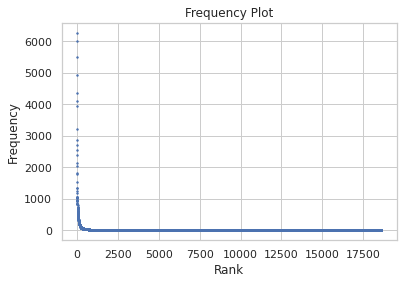

In [33]:
# frequency plot (rank/ frequency)
fig, ax = plt.subplots()
ax.scatter(VOCABULARY['hate']['rank'], VOCABULARY['hate']['frequency'],  s=2);
ax.set_title('Frequency Plot'); ax.set_xlabel('Rank'); ax.set_ylabel('Frequency');

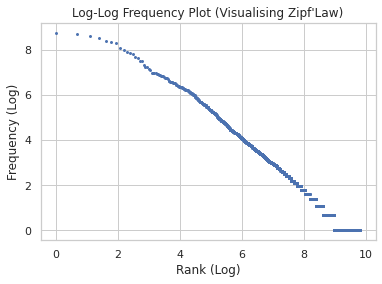

In [34]:
# log-log plot for zipf's law
fig, ax = plt.subplots()
plt.scatter(np.log(VOCABULARY['hate']['rank']), np.log(VOCABULARY['hate']['frequency']), s=15,marker=".")
ax.set_title("Log-Log Frequency Plot (Visualising Zipf'Law)"); ax.set_xlabel('Rank (Log)'); ax.set_ylabel('Frequency (Log)');

## Emotional Plots

In [35]:
one_occurance=VOCABULARY['hate']['frequency']==1

In [36]:
#VOCABULARY['hate'][one_occurance]

*TASK 2*
# XXX
---

In [37]:
# some code

## Exercise 2

In [38]:
from nltk.util import bigrams
list(bigrams(DATA['processed']["emotion"]["train_text"][0]))

[('“', 'worry'),
 ('worry', 'is'),
 ('is', 'a'),
 ('a', 'down'),
 ('down', 'payment'),
 ('payment', 'on'),
 ('on', 'a'),
 ('a', 'problem'),
 ('problem', 'you'),
 ('you', 'may'),
 ('may', 'never'),
 ('never', 'have'),
 ('have', "'"),
 ("'", '.'),
 ('.', 'joyce'),
 ('joyce', 'meyer'),
 ('meyer', '.'),
 ('.', '#motivation'),
 ('#motivation', '#leadership'),
 ('#leadership', '#worry')]

In [39]:
#Adds A <s> to before the first word to indicate that it's the start and an </s> to the end the word to do it
from nltk.util import pad_sequence
list(pad_sequence(DATA['processed']["emotion"]["train_text"][0],
pad_left=True,
left_pad_symbol="<s>",
pad_right=True,
right_pad_symbol="</s>",
n=2))

['<s>',
 '“',
 'worry',
 'is',
 'a',
 'down',
 'payment',
 'on',
 'a',
 'problem',
 'you',
 'may',
 'never',
 'have',
 "'",
 '.',
 'joyce',
 'meyer',
 '.',
 '#motivation',
 '#leadership',
 '#worry',
 '</s>']

In [40]:
from nltk.lm.preprocessing import pad_both_ends
list(pad_both_ends(DATA['processed']["emotion"]["train_text"][0], n=2))

['<s>',
 '“',
 'worry',
 'is',
 'a',
 'down',
 'payment',
 'on',
 'a',
 'problem',
 'you',
 'may',
 'never',
 'have',
 "'",
 '.',
 'joyce',
 'meyer',
 '.',
 '#motivation',
 '#leadership',
 '#worry',
 '</s>']

In [41]:
list(bigrams(pad_both_ends(DATA['processed']["emotion"]["train_text"][0], n=2)))

[('<s>', '“'),
 ('“', 'worry'),
 ('worry', 'is'),
 ('is', 'a'),
 ('a', 'down'),
 ('down', 'payment'),
 ('payment', 'on'),
 ('on', 'a'),
 ('a', 'problem'),
 ('problem', 'you'),
 ('you', 'may'),
 ('may', 'never'),
 ('never', 'have'),
 ('have', "'"),
 ("'", '.'),
 ('.', 'joyce'),
 ('joyce', 'meyer'),
 ('meyer', '.'),
 ('.', '#motivation'),
 ('#motivation', '#leadership'),
 ('#leadership', '#worry'),
 ('#worry', '</s>')]

In [42]:
from nltk.lm.preprocessing import flatten
list(flatten(pad_both_ends(sent, n=2) for sent in DATA['processed']["emotion"]["train_text"][:100]))

['<s>',
 '“',
 'worry',
 'is',
 'a',
 'down',
 'payment',
 'on',
 'a',
 'problem',
 'you',
 'may',
 'never',
 'have',
 "'",
 '.',
 'joyce',
 'meyer',
 '.',
 '#motivation',
 '#leadership',
 '#worry',
 '</s>',
 '<s>',
 'my',
 'roommate',
 ':',
 'it',
 'is',
 'okay',
 'that',
 'we',
 'cannot',
 'spell',
 'because',
 'we',
 'have',
 'autocorrect',
 '.',
 '#terrible',
 '#firstworldprobs',
 '</s>',
 '<s>',
 'no',
 'but',
 'that',
 'is',
 'so',
 'cute',
 '.',
 'atsu',
 'was',
 'probably',
 'shy',
 'about',
 'photos',
 'before',
 'but',
 'cherry',
 'helped',
 'her',
 'out',
 'uwu',
 '</s>',
 '<s>',
 'rooneys',
 'fucking',
 'untouchable',
 'is',
 'not',
 'he',
 '?',
 'been',
 'fucking',
 'dreadful',
 'again',
 ',',
 'depay',
 'has',
 'looked',
 'decent',
 '(',
 'ish',
 ')',
 'tonight',
 '</s>',
 '<s>',
 'it',
 'is',
 'pretty',
 'depressing',
 'when',
 'you',
 'hit',
 'pan',
 'on',
 'ur',
 'favourite',
 'highlighter',
 '</s>',
 '<s>',
 '@user',
 'but',
 'your',
 'pussy',
 'was',
 'weak',
 'from'

In [43]:
from nltk.lm.preprocessing import padded_everygram_pipeline
train, vocab = padded_everygram_pipeline(3, DATA['processed']["hate"]["train_text"])

In [44]:
from nltk.lm import MLE
lm = MLE(5)

In [45]:
len(lm.vocab)

0

In [46]:
lm.fit(train, vocab)
print(lm.vocab)
len(lm.vocab)

<Vocabulary with cutoff=1 unk_label='<UNK>' and 18603 items>


18603

In [47]:
print(lm.counts)

<NgramCounter with 3 ngram orders and 729228 ngrams>


In [48]:
lm.counts[['.']]["</s>"]

1399

In [49]:
lm.score(".", ["</s>"])

0.0

In [50]:
lm.score("randomString")

0.0

In [51]:
 test = [('I', 'am'), ('I', 'hate')]

In [52]:
 lm.entropy(test)

inf

In [53]:
lm.perplexity(test)

inf

"your girlfriend looking at injustices happening in andrew"

'they should understand women cheats on my 16gb of action against their bodies on legs'

#peoplelikemebecause actions. #lovejihad

'betray your hole last weekend me want more' <br>
'hitler may come back'

In [54]:
lm.generate(10, text_seed=["You","are","a","stupid"], random_seed=5)

['fucking', 'idiot', 'hoe', 'i', '’', 've', 'accused', 'him', 'of', 'rape']

In [55]:
from nltk.util import ngrams
text_bigrams = [ngrams(sent, 2) for sent in DATA['processed']["hate"]["train_text"]]
text_unigrams = [ngrams(sent, 1) for sent in DATA['processed']["hate"]["train_text"]]

In [56]:
from nltk.lm import NgramCounter
ngram_counts = NgramCounter(text_bigrams + text_unigrams)

In [57]:
ngram_counts["I"]

414

*TASK 3*
# Manual Annotations and Inter-Annotator Agreement

In this section, we will manually annotate 100 randomly selected tweets from the train corpus in the hate speech data set. We followed the annotation guidelines as employed by the source of the data:

[Final Paper](https://www.aclweb.org/anthology/S19-2007.pdf)

[Annotation Guidelines](https://github.com/msang/hateval/blob/master/annotation_guidelines.md)

In [58]:
GENERATE_SAMPLE = False

In [59]:
if GENERATE_SAMPLE == True:
    with open('../data/annotations/annotation_sample.txt', 'w') as outfile:
        for tweet in DATA['raw']['hate']['train_text'][-100:]: # last 100 tweets in hate training set
            outfile.writelines(tweet + '\n')
    with open('../data/annotations/ground_truth_annotation_sample.txt', 'w') as outfile:
        for label in DATA['raw']['hate']['train_labels'][-100:]:
            outfile.writelines(str(label) + '\n')

In [60]:
# compare manual annotations through building dataframe
annotation_evaluation = pd.DataFrame({'tweets': DATA['raw']['hate']['train_text'][-100:], 'ground_truth': DATA['raw']['hate']['train_labels'][-100:]})

for filename in os.listdir('../data/annotations/manual_annotations'):
    with open(f'../data/annotations/manual_annotations/{filename}', 'r') as infile:
        annotation_evaluation[filename[:-4]] = [int(line.strip()) for line in infile.readlines()]

In [61]:
annotation_evaluation

,tweets,ground_truth,nicola_annotations,hugo_annotations,mika_annotations,aidan_annotations
0,Cry baby Hollywood Dems Anti-Trump celebs too ...,0,0,0,0,0
1,@user Do I have to fight another bitch ass loo...,1,1,0,1,1
2,#SouthCarolina has spent millions of dollars t...,0,0,0,0,0
3,Me trying to flirt- I wanna eat your hot pocket,0,0,0,0,0
4,"People say, ""Why didn't this or that immigrant...",0,0,0,0,0
...,...,...,...,...,...,...
95,Oooohhhh bitch didn't even listen to the dead ...,0,1,0,0,1
96,@user Good Luck @user More Americans #WalkAway...,0,1,0,0,0
97,Bitch you can't keep up so stop trying,1,1,0,1,0
98,@user @user @user @user @user @user Japan is a...,0,0,0,0,0


In [170]:
##compare what tweets were unanimously and un-unanimously annotated
rel_columns=list(annotation_evaluation.columns)
rel_columns.remove('tweets')
rel_columns=annotation_evaluation[rel_columns]
all_true=rel_columns.all(axis=1)
all_false=-rel_columns.any(axis=1)
un_unanimous=annotation_evaluation[-all_true & -all_false]
unanimous=annotation_evaluation[all_true | all_false]
unanimous

,tweets,ground_truth,nicola_annotations,hugo_annotations,mika_annotations,aidan_annotations
0,Cry baby Hollywood Dems Anti-Trump celebs too ...,0,0,0,0,0
2,#SouthCarolina has spent millions of dollars t...,0,0,0,0,0
3,Me trying to flirt- I wanna eat your hot pocket,0,0,0,0,0
4,"People say, ""Why didn't this or that immigrant...",0,0,0,0,0
6,#landdegradation undermines the well-being of ...,0,0,0,0,0
8,Two faced Boris now hes on a power trip dosent...,0,0,0,0,0
10,@user I hope you are not offering them a choic...,1,1,1,1,1
13,I feel like post birth abortion should be a th...,0,0,0,0,0
14,UN countries agree on pact to manage mass glob...,0,0,0,0,0
16,Populists are not anti immigrant or anti immig...,0,0,0,0,0


In [63]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

for person in list(annotation_evaluation)[-4:]:
    print('#'*3 + ' ' + person.replace('_',' ').title() + ' ' + '#'*3)    
    print(pd.DataFrame(confusion_matrix(annotation_evaluation['ground_truth'], annotation_evaluation[person]), columns=['Predicted Non-Hate', 'Predicted Hate'], index=['Non-Hate', 'Hate']))
    print('\n')
    
    print(classification_report(annotation_evaluation['ground_truth'], annotation_evaluation[person], target_names=["Non-Hate","Hate"]))
    print('\n')

### Nicola Annotations ###
          Predicted Non-Hate  Predicted Hate
Non-Hate                  51               6
Hate                       7              36


              precision    recall  f1-score   support

    Non-Hate       0.88      0.89      0.89        57
        Hate       0.86      0.84      0.85        43

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



### Hugo Annotations ###
          Predicted Non-Hate  Predicted Hate
Non-Hate                  57               0
Hate                      28              15


              precision    recall  f1-score   support

    Non-Hate       0.67      1.00      0.80        57
        Hate       1.00      0.35      0.52        43

    accuracy                           0.72       100
   macro avg       0.84      0.67      0.66       100
weighted avg       0.81      0.72      0.68       100



### Mika Annotat

*TASK 4*
# Automatic Prediction XXX
---

In [64]:
### imports for models, to be moved up later
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

import nltk
from nltk.corpus import stopwords

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

from matplotlib.ticker import MaxNLocator

In [65]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Balancing the data
#this can be done in the model training funciton but for ease of testing it is currently here

In [101]:
from imblearn.over_sampling import SMOTE

In [113]:
smote_ = SMOTE(random_state=42)
Dataset = "hate"
min_frequency = 1
X_bal, y_bal = smote_.fit_resample(text_format (Dataset,
    remove_stop_uncommon(DATA["processed"][Dataset]["train_text"],min_frequency,VOCABULARY[Dataset]),tvt="train"),
    DATA['processed'][Dataset]['train_labels'])

In [114]:
model_b = SGDClassifier(loss='log')
model_b.fit(X_bal,y_bal)

SGDClassifier(loss='log')

Text(0.5, 1.0, 'Accuracy and Minimum Word Frequecy')

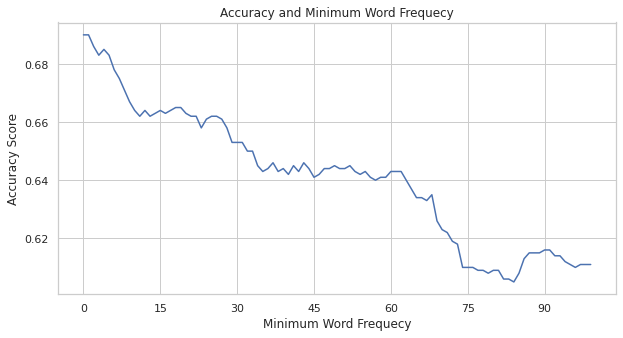

In [132]:
accuracies=[]
for i in range(100):
    prediction = model_b.predict(text_format(Dataset,remove_stop_uncommon(DATA["processed"][Dataset][f"val_text"],i,VOCABULARY[Dataset],remove_stop=False),tvt="val"))
    actual = DATA["processed"][Dataset][f"val_labels"] 
    accuracies.append(accuracy_score(actual, prediction))
ax = plt.figure(figsize=(10,5)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot([x for x in range (100)],accuracies)
ax.set_xlabel("Minimum Word Frequecy")
ax.set_ylabel("Accuracy Score")
ax.set_title("Accuracy and Minimum Word Frequecy")

Text(0.5, 1.0, 'Accuracy and Minimum Word Frequecy')

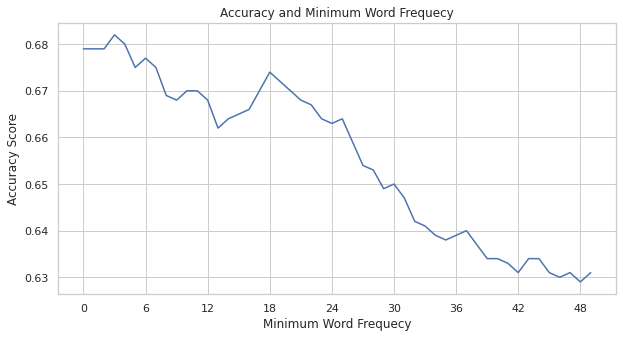

In [161]:
accuracies=[]
for i in range(50):
    prediction = model_b.predict(text_format(Dataset,remove_stop_uncommon(DATA["processed"][Dataset][f"val_text"],i,VOCABULARY[Dataset],remove_stop=True),tvt="val"))
    actual = DATA["processed"][Dataset][f"val_labels"] 
    accuracies.append(accuracy_score(actual, prediction))
ax = plt.figure(figsize=(10,5)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot([x for x in range (50)],accuracies)
ax.set_xlabel("Minimum Word Frequecy")
ax.set_ylabel("Accuracy Score")
ax.set_title("Accuracy and Minimum Word Frequecy")

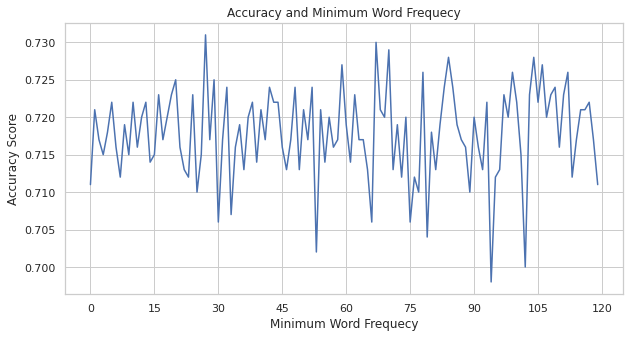

In [140]:
plot_accuracy(120,"hate","Baseline") ##something is def wrong here, wtf?

### Models

##### Some helper functions that are used for the model -

In [212]:
def dummy(doc):
    return doc
    
def text_format(dataset, tokenised,tvt="val"):
    """formats the data into a format that is readable by the models"""
    cv = CountVectorizer(tokenizer=dummy, preprocessor=dummy) 
    cv.fit(DATA["processed"][dataset]["train_text"])
    if tvt=="train":
        X_train_counts = cv.transform(DATA["processed"][dataset]["train_text"])
        #tfidf_transformer = TfidfTransformer()
        #fitted_transform=tfidf_transformer.fit(X_train_counts)#fit to the test vocab
        #X_tfidf = fitted_transform.transform(X_train_counts)
    else:
        X_train_counts = cv.transform(tokenised)
        #X_tfidf = fitted_transform.transform(X_train_counts)# read into what this does
    return X_train_counts #X_tfidf

In [213]:
def remove_stop_uncommon(tokenised,min_frequency,vocab,remove_stop=False):
    stop_words=set()
    if remove_stop==True:
        stop_words = set(stopwords.words('english'))
    temp_vocab_dict={vocab['index'][x]:vocab['frequency'][x] for x in range(vocab.shape[0])}
    #   <- make work later
    #if not in the temp vocab dict then append as 0
    for token_list in tokenised:
        for token in token_list:
            try: temp_vocab_dict[token]=temp_vocab_dict[token]
            except: temp_vocab_dict[token]= 0
    #print("hi",len([[item for item in list_ if item not in stop_words and temp_vocab_dict[item]>=min_frequency]for list_ in tokenised][0]))
    return [[item for item in list_ if item not in stop_words and temp_vocab_dict[item]>=min_frequency]for list_ in tokenised]

In [220]:
def fit_model(Classifier,Dataset,min_frequency=1,balance=True,remove_stop_=True):
    if balance==True:
        X, y = smote_.fit_resample(text_format (Dataset,
    remove_stop_uncommon(DATA["processed"][Dataset]["train_text"],min_frequency,VOCABULARY[Dataset],remove_stop=remove_stop_),tvt="train"),
    DATA['processed'][Dataset]['train_labels'])
    else:
        X =text_format (Dataset,remove_stop_uncommon(DATA["processed"][Dataset]["train_text"],min_frequency,VOCABULARY[Dataset],remove_stop=True),tvt="train")
        y = DATA['processed'][Dataset]['train_labels']
    if Classifier=="RFC":
        model = RandomForestClassifier(max_depth=None, n_estimators=100,random_state=0)
    elif Classifier=="MNB":
        model=MultinomialNB(alpha=0.)### this alpha value at its defaut may actually give better results
    elif Classifier=="Baseline":
        model = SGDClassifier(loss='log')
    return model.fit(X,y)

In [215]:
def model_accuracy_val(min_frequency,Dataset,model,v_or_t="val",remove_stop_=False):
    """takes cleaned and tokensed data and returns accuracy score of the model"""
    if v_or_t !="val":
        v_or_t="test"
        print("warning! you are using the test data")
    prediction = model.predict(text_format(Dataset,remove_stop_uncommon(DATA["processed"][Dataset][f"{v_or_t}_text"],min_frequency,VOCABULARY[Dataset],remove_stop=remove_stop_),tvt=v_or_t))
    actual = DATA["processed"][Dataset][f"{v_or_t}_labels"]
    return accuracy_score(actual, prediction)

In [216]:
def model_prf_score(Dataset,min_frequency,model,v_or_t="val",remove_stop_=False):###dont need min freq here probably
    """takes cleaned and tokensed data and returns precision, recall and F-score of the model"""
    if v_or_t !="val":
        v_or_t="test"
        print("warning! you are using the test data")
    prediction = model.predict(text_format(Dataset,remove_stop_uncommon(DATA["processed"][Dataset][f"{v_or_t}_text"],min_frequency,VOCABULARY[Dataset],remove_stop=remove_stop_),tvt=v_or_t))
    actual = DATA["processed"][Dataset][f"{v_or_t}_labels"] 
    scores= precision_recall_fscore_support(actual,prediction)
    order=list(DATA["raw"][Dataset]["mapping"].values())
    score_labels=["precision","recall","F-score", "Support"]
    for i,label in enumerate(order):
        score_dataframe=pd.DataFrame(data=scores,columns=order,index=score_labels)
        return score_dataframe

In [230]:
def plot_accuracy(max_vocab,Dataset,model,ax,remove_stop__=False):
    accuracies=[]
    for i in range (max_vocab):
        accuracies.append(model_accuracy_val(i,Dataset,model,remove_stop_=remove_stop__))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.plot([x for x in range (max_vocab)],accuracies)
    ax.set_xlabel("Minimum Word Frequecy")
    ax.set_ylabel("Accuracy Score")
    ax.set_title("Accuracy and Minimum Word Frequecy in Validation Data")

#### Code for Hate

In [222]:
MNB_hate=fit_model("MNB","hate",balance=False,remove_stop_=False)
MNB_hate_bal=fit_model("MNB","hate",remove_stop_=False)
MNB_hate_stop=fit_model("MNB","hate",balance=False)
MNB_hate_bal_stop=fit_model("MNB","hate")

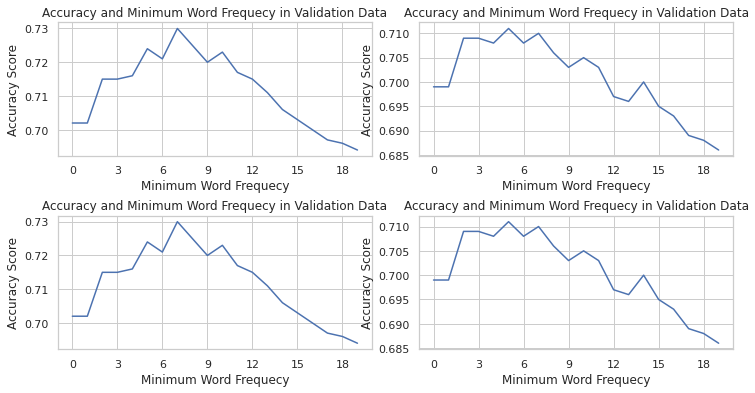

In [244]:
#takes a while to run be here we see that a min freq val of 7/8 is best, this also holds up to 100 and we can assume it holds above 100
fig,ax= plt.subplots(2,2,figsize=(10,5))
fig.tight_layout(pad=0.4, w_pad=1, h_pad=3.0)
frequency=20
plot_accuracy(frequency,"hate",MNB_hate,ax=ax[0,0])
plot_accuracy(frequency,"hate",MNB_hate_bal,ax=ax[0,1])
plot_accuracy(frequency,"hate",MNB_hate_stop,ax=ax[1,0])
plot_accuracy(frequency,"hate",MNB_hate_bal_stop,ax=ax[1,1])

In [249]:
model_prf_score("hate",7,MNB_hate_bal)## use best model here later

,not-hate,hate
precision,0.823799,0.621670
recall,0.628272,0.819672
F-score,0.712871,0.707071
Support,573.000000,427.000000


In [251]:
model_prf_score("hate",7,MNB_hate,remove_stop_=False)

,not-hate,hate
precision,0.808554,0.654224
recall,0.692845,0.779859
F-score,0.746241,0.711538
Support,573.000000,427.000000


#### Multiclass Emotions 

In [240]:
MNB_emotion=fit_model("MNB","emotion",balance=False,remove_stop_=False)
MNB_emotion_bal=fit_model("MNB","emotion",remove_stop_=False)
MNB_emotion_stop=fit_model("MNB","emotion",balance=False)
MNB_emotion_bal_stop=fit_model("MNB","emotion")

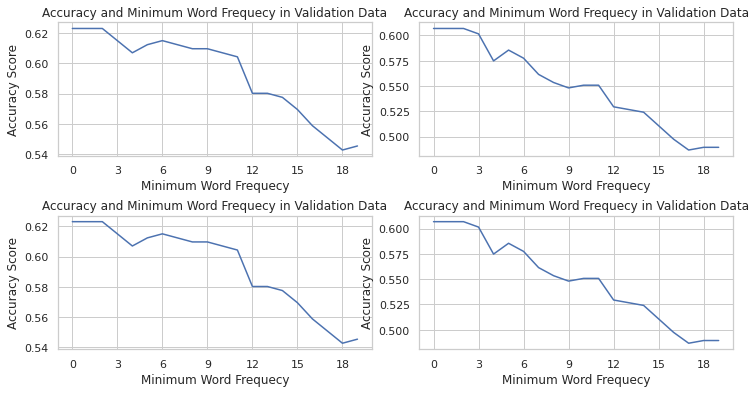

In [245]:
fig,ax= plt.subplots(2,2,figsize=(10,5))
fig.tight_layout(pad=0.4, w_pad=1, h_pad=3.0)
frequency=20
plot_accuracy(frequency,"emotion",MNB_emotion,ax=ax[0,0])
plot_accuracy(frequency,"emotion",MNB_emotion_bal,ax=ax[0,1])
plot_accuracy(frequency,"emotion",MNB_emotion_stop,ax=ax[1,0])
plot_accuracy(frequency,"emotion",MNB_emotion_bal_stop,ax=ax[1,1])

In [247]:
model_prf_score("emotion",1,)

NameError: name 'clf' is not defined

In [81]:
#prediction = clf.predict(text_format("emotion",remove_stop_uncommon(DATA["processed"]["emotion"]["val_text"],1,VOCABULARY["emotion"]),tvt="val"))
#actual = DATA["processed"]["emotion"]["val_labels"]

In [82]:
#confusion_matrix(actual,prediction, labels=None, sample_weight=None, normalize=None)

#### Baseline for hate

In [83]:
baseline_hate_10=fit_model("Baseline","hate",10)

In [84]:
#model_accuracy("hate",1,baseline)

In [85]:
#plot_accuracy(100,"hate",baseline)

In [86]:
#model_prf_score("hate",24,baseline)

#### Baseline for Emotion

In [87]:
baseline_emotion_10=fit_model("Baseline","emotion",10)

In [88]:
#model_accuracy("emotion",1,baseline)

In [89]:
#plot_accuracy(100,"emotion",baseline)

In [90]:
#model_prf_score("emotion",1,baseline)

### Random Forrest

#### Hate

In [91]:
RFC_hate_10=fit_model("RFC","hate",10)

In [92]:
#plot_accuracy(30,"hate",Forest)

In [93]:
#model_prf_score("hate",13,Forest)

#### Emotion

In [94]:
RFC_emotion_10=fit_model("RFC","emotion",10)

In [95]:
#plot_accuracy(100,"emotion",Forest)

In [96]:
#model_prf_score("emotion",1,Forest)

# Testing

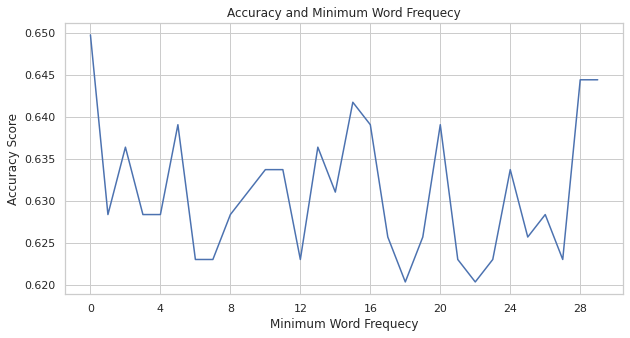

In [97]:
plot_accuracy(30,"emotion","Baseline")###this plot should not look like this..... :(

In [98]:
model_accuracy("hate",100000,"RFC")## so with no information in the model the model predicts correctly 72% of the time???????? how?

0.715

* use stop words for filtering out filler words -done
* filter out uncommon words using vocab frequency -done
* model for all emotions, make into function?
* deal with any problems that arrise - some things need ironing out, see comments
* task 2 descriptive things
* start paper 
* correct spelling
* make the formatting of the notebook good enough to be readable
* understanding laplace or better estimate instead -smoothing
* improvements:

- [x] remove min freq
- [x] random forrest
- [x] stopwords (make comparable)
- [x] Multinomial NB model -why and whats different 
- [ ] tfidf (made comparable)
- [ ] loss parameter
* make some graphics to compare



# Still need to balance the data!!!!!!

if we add a smooting on the multinomialNB by removing the alpha=0. parmeter then the results are better but different. worth looking into as a group, can ammend functions later to accomodate- nicola

### Summary of this morining:
* The mNB classifier may work better with the default alpha perameter which applies smoothing
* the accuracy functions were showing the wrong as we should be TRAINING the models on different min freq data not validationg with different min_freq data (although this also might make a difference, im confused).
* i tried to fix the above, but in doing so somehow broke it... Now(and im not sure if this was also happening before) the modle has a high accuracy even if the data it is being trained on is technically empty lists. This cant be the case right? so there must be an errror in the code somewhere (a beer on me if you can find it :')), unless this has something to do with balancing not being done yet.
* in better news, i made a fit_model function which is now used whe fitting models. This streamlines our code quite a bit. im fairly sure it is working correctly and isnt the source ofthe abov issure but i may be wrong.
* i also had a look at the random forest parameters but decided to keep everything the same as we had it before as nothing i did impacted the accuracy score much(before it broke)(the ntrees is 100 temporarily for ease of runnnig the code)
* we always have to old functions on previous versions so if we get realy stuck we can go from there.
* suggested next steps:

* [ ] task 2 (see the project description) most has been done but needs to be collected into one readable section
* [ ] balncing of data



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7ea65742-831a-48cd-9d56-a22e1ed66c7b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>